In [1]:
# requires separate environment for cellpose - older versions of numpy (see segmentation.yaml)
import os
import os.path as path
import sys
import numpy as np
import importlib
import tifffile
import matplotlib.pyplot as plt
from cellpose import models, io, plot, utils
from collections import defaultdict
from cellpose.io import imread
from matplotlib.patches import Polygon, Rectangle
import skimage
from scipy.ndimage import distance_transform_edt

from skimage import measure
import pandas as pd
import json

io.logger_setup()

# reproduce saved results
import random
random.seed(123)
np.random.seed(123)
import torch
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2025-04-07 12:02:01,486 [INFO] WRITING LOG OUTPUT TO /Users/jabrand2/.cellpose/run.log
2025-04-07 12:02:01,488 [INFO] 
cellpose version: 	3.1.1.1 
platform:       	darwin 
python version: 	3.8.5 
torch version:  	2.2.2


In [2]:
# notebook directory
current_dir = os.getcwd()

# project directory
root_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
os.chdir(root_dir)

# for importing segmentation utils
sys.path.append(os.path.join(root_dir, 'scripts', 'notebooks'))

import segmentation_utils

In [3]:
# image file 
kidney_path = os.path.join(os.getcwd(), 'example_data', 'kidney', 'raw', 'melc_kidney_tumor')

# List all TIFF files in the directory
tiff_files = [f for f in os.listdir(kidney_path) if f.endswith('.tif')]

# reorder so DAPI is 0th index (1st slice, needed in segmentation)
tiff_files.remove('DAPI.tif')
tiff_files.insert(0, 'DAPI.tif')

first_image = tifffile.imread(os.path.join(kidney_path, tiff_files[0]))
height, width = first_image.shape

# initialize image stack
image_stack = np.zeros((len(tiff_files), height, width), dtype = first_image.dtype)

for i, tiff in enumerate(tiff_files):
    image_stack[i] = tifffile.imread(os.path.join(kidney_path, tiff))

# normalize if not 0-255 range for pixel intensity
image_stack = segmentation_utils.normalize_image(image_stack)

In [4]:
# save out marker info
marker_info = [f[:-4] for f in tiff_files] # drops .tif extension
pd.DataFrame(marker_info).to_csv(os.path.join(root_dir, 'example_data', 'kidney', 'raw', 'channelnames.txt'), header = False, index = False)

# save out normalized image:
#tifffile.imwrite(os.path.join(root_dir, 'example_data', 'kidney', 'processed', 'normalized_kidney.tif'), image_stack)

In [5]:
plt.figure(figsize = (2, 2))
plt.imshow(image_stack[0,:,:]) # DAPI channel in first image slice
plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
# nuclei model for segmentation, cell boundaries expanded in later step
model = models.Cellpose(model_type = 'nuclei')

2025-04-07 12:02:02,417 [INFO] >>>> using CPU
2025-04-07 12:02:02,420 [INFO] >>>> using CPU
2025-04-07 12:02:02,423 [INFO] >> nuclei << model set to be used
2025-04-07 12:02:02,486 [INFO] >>>> loading model /Users/jabrand2/.cellpose/models/nucleitorch_0
2025-04-07 12:02:02,602 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)


In [7]:
# see documentation for cellpose for setting parameters:

# https://cellpose.readthedocs.io/en/latest/api.html
# Stringer, C. et al. Cellpose: a generalist algorithm for cellular segmentation. 
# Nat Methods 18, 100–106 (2021). https://doi.org/10.1038/s41592-020-01018-x

masks, flows, styles, diameter = model.eval(image_stack[0,:,:], 
                                            channels = [0, 0], # DAPI
                                            diameter = 30, # will predict if not provided
                                            cellprob_threshold = -3, # default is 0 (sigmoid ouput -6 to 6 range, see cellpose documentation)
                                            flow_threshold = 0.8, 
                                            resample = False, 
                                            channel_axis = 0)

plt.figure(figsize = (2,2))
plt.imshow(masks)

2025-04-07 12:02:02,617 [INFO] channels set to [0, 0]
2025-04-07 12:02:02,619 [INFO] ~~~ FINDING MASKS ~~~
2025-04-07 12:02:26,130 [INFO] >>>> TOTAL TIME 23.51 sec


In [8]:
# this can be skipped and used masks / outlines for donwstream expression measures if desired
expanded_masks = segmentation_utils.expand_areas(nuclear_masks = masks, expansion_distance = 5)
outlines = utils.outlines_list(masks)
expanded_outlines = utils.outlines_list(expanded_masks)

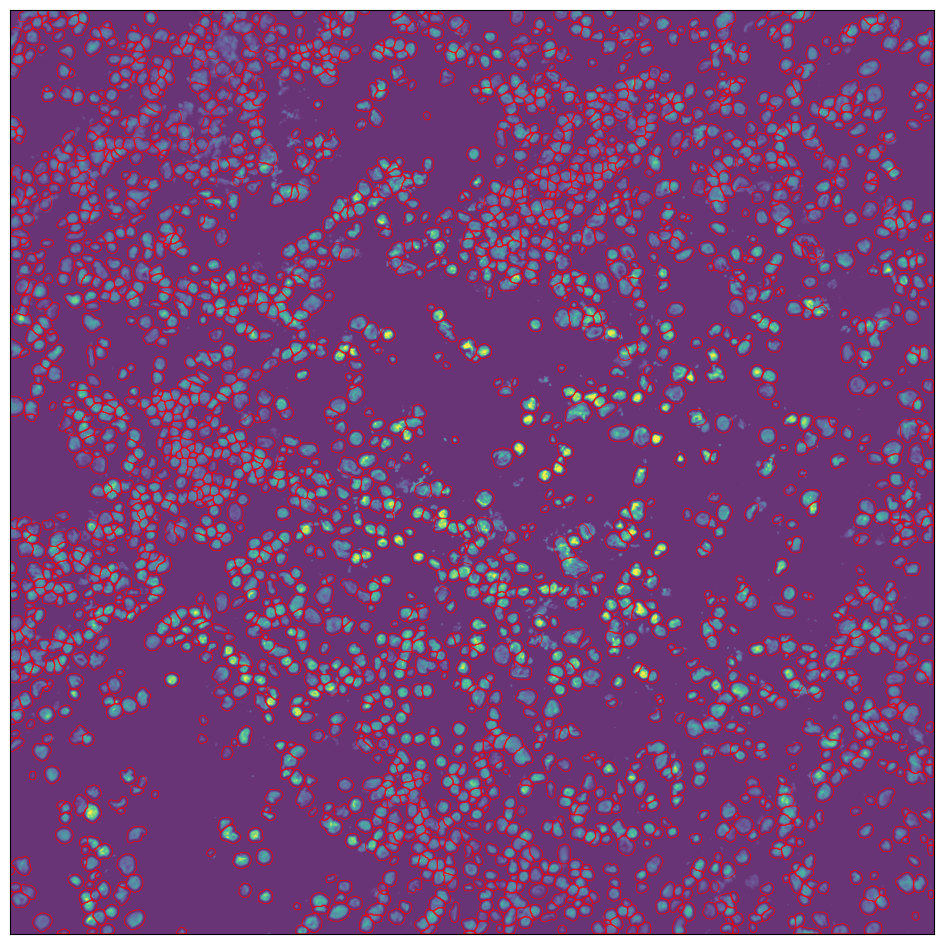

In [9]:
# polygons around points, to be used for average expression measures
plt.figure(figsize = (12, 12))
plt.imshow(image_stack[0, :, :], alpha = 0.8, vmin = 0, vmax = 255)
plt.xticks([])
plt.yticks([])
for outline in expanded_outlines:
    plt.plot(outline[:,0], outline[:,1], color = 'r', linewidth = 0.5)

In [10]:
# saving out segmentations from model
# non-expanded
io.masks_flows_to_seg(images = image_stack, # first image in stack (if processing multiple images)
                      masks = masks, 
                      flows = flows, 
                      file_names = './example_data/kidney/segmentations/kidney', 
                      channels = [0,0], 
                      diams = 30)

# expanded (used for features calculations)
io.masks_flows_to_seg(images = image_stack, 
                      masks = expanded_masks, 
                      flows = flows, 
                      file_names = './example_data/kidney/segmentations/kidney_expanded', 
                      channels = [0,0], 
                      diams = 30)

In [11]:
# load back segmentations
segs = np.load(os.path.join(os.getcwd(),
                            './example_data/kidney/segmentations/kidney_expanded_seg.npy'), 
               allow_pickle = True).item()

non_expanded_segs = np.load(os.path.join(os.getcwd(),
                            './example_data/kidney/segmentations/kidney_seg.npy'), 
               allow_pickle = True).item()

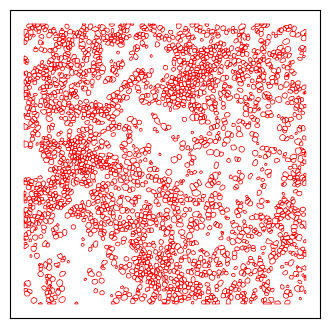

In [12]:
# showing only cell segmentations, inverted relative to image (need -1*Y coord)
# consider bottom right coordinate as landmark
plt.figure(figsize = (4, 4))
plt.xticks([])
plt.yticks([])
for outline in expanded_outlines:
    plt.plot(outline[:,0], -1*outline[:,1], color = 'r', linewidth = 0.5)

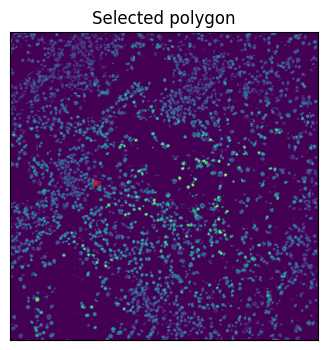

In [13]:
# example of identifying individual cells by polgyon
cell_ix = np.random.randint(0, len(expanded_outlines))
polygon_vertices = expanded_outlines[cell_ix] 
x,y = polygon_vertices[:,0], polygon_vertices[:,1]

plt.figure(figsize = (4,4))
plt.imshow(image_stack[0,:,:])
plt.plot(x, y, color = 'red', linewidth = 1)
plt.title('Selected polygon')
plt.xticks([]) 
plt.yticks([])
plt.show()

In [14]:
# averaging pixel intensity in each mask
exprs = segmentation_utils.average_expression(image = image_stack, 
                                              masks = expanded_masks,
                                              outlines = expanded_outlines,
                                              marker_info = marker_info,
                                              log = True, # log noramlize values
                                              clip_low = 0.1, # clamp to bottom and top %
                                              clip_high = 0.99)

clipping values between: 0.1 - 0.99 %-iles


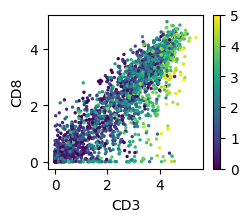

In [15]:
# Expression of example celltype markers is consistent with expectation
plt.figure(figsize = (2.5,2))
plt.scatter(x = exprs['CD3_Cell_Mean'], 
            y = exprs['CD8_Cell_Mean'], 
            s = 2, c = exprs['CD4_Cell_Mean'], 
            vmin = 0, vmax = 5, # set depending on background intensities / max intensities
            cmap = 'viridis')
plt.colorbar()
plt.xlabel('CD3')
plt.ylabel('CD8')
plt.show()

In [16]:
# calculate centroids from outlines and add to final dataframe
centroids = [segmentation_utils.calculate_centroid(polygon) for polygon in expanded_outlines]
x_y = pd.DataFrame(centroids, columns=['Centroid_X', 'Centroid_Y'])
plot_df = pd.concat([exprs, x_y], axis = 1)

In [17]:
markers = {
    'CD3': {'column': 'CD3_Cell_Mean', 'vmin': 2.5, 'vmax': 5, 'title': 'CD3'},
    'CD4': {'column': 'CD4_Cell_Mean', 'vmin': 3, 'vmax': 4, 'title': 'CD4'},
    'CD8': {'column': 'CD8_Cell_Mean', 'vmin': 2.5, 'vmax': 4, 'title': 'CD8'}
}

fig, axes = plt.subplots(1, len(markers.keys()), figsize = (12, 3),gridspec_kw = {'wspace': 0.1})

# Plot each marker
for ax, (marker, info) in zip(axes, markers.items()):
    ix = int(np.where(plot_df.columns == info['column'])[0])
    scatter = ax.scatter(plot_df['Centroid_X'], plot_df['Centroid_Y'],
                        vmin = info['vmin'], 
                        vmax = info['vmax'],
                        c = plot_df[info['column']], 
                        cmap = 'viridis', 
                        s = 10, edgecolor = 'black', linewidth = 0.2)
    ax.set_title(info['title'])
    ax.set_facecolor('black')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(scatter, ax = ax)
plt.show()

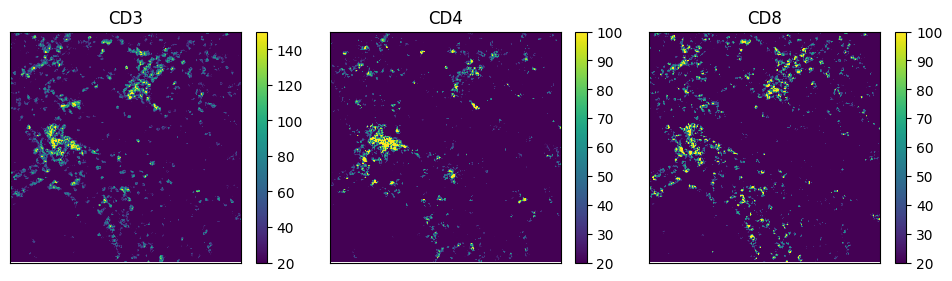

In [18]:
markers = {
    'CD3': {'column': 'CD3_Cell_Mean', 'vmin': 20, 'vmax': 150, 'title': 'CD3'},
    'CD4': {'column': 'CD4_Cell_Mean', 'vmin': 20, 'vmax': 100, 'title': 'CD4'},
    'CD8': {'column': 'CD8_Cell_Mean', 'vmin': 20, 'vmax': 100, 'title': 'CD8'}
}

fig, axes = plt.subplots(1, len(markers.keys()), figsize = (12, 3),gridspec_kw = {'wspace': 0.1})

# Plot each marker
for ax, (marker, info) in zip(axes, markers.items()):
    ix = int(np.where(plot_df.columns == info['column'])[0])
    scatter = ax.imshow(image_stack[ix,:,:],
                        vmin = info['vmin'], 
                        vmax = info['vmax'],
                        cmap = 'viridis')
    ax.set_title(info['title'])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(scatter, ax = ax)
plt.show()

In [19]:
plot_df['original_cell'] = [f'cell_{id}' for id in range(0, plot_df.shape[0])]
plot_df['Object.ID'] = [segmentation_utils.generate_key() for id in range(0, plot_df.shape[0])]
plot_df.set_index('Object.ID', inplace = True)

In [20]:
importlib.reload(segmentation_utils)

<module 'segmentation_utils' from '/Users/jabrand2/Desktop/codex_python/scripts/notebooks/segmentation_utils.py'>

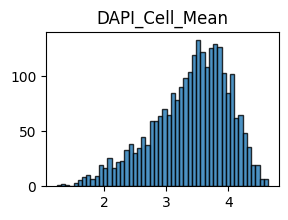

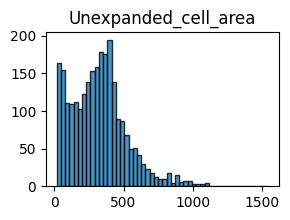

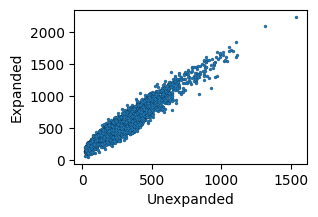

In [21]:
plot_df['Cell_area'] = [segmentation_utils.calc_cell_area(cell) for cell in expanded_outlines]
plot_df['Unexpanded_cell_area'] = [segmentation_utils.calc_cell_area(cell) for cell in outlines]

segmentation_utils.qc_plots(expression_data = plot_df, plot_show = 1)
segmentation_utils.qc_plots(expression_data = plot_df, plot_show = 2)

plt.figure(figsize = (3,2))
plt.scatter(x = plot_df['Unexpanded_cell_area'], 
            y =  plot_df['Cell_area'], 
           s = 5, edgecolors = 'black', linewidths = 0.1)
plt.xlabel('Unexpanded')
plt.ylabel('Expanded')
plt.show()

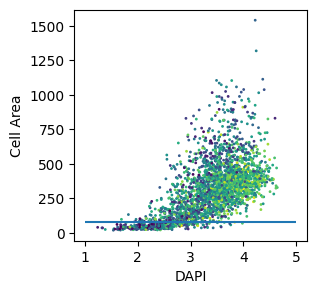

In [22]:
plot_df.loc[:,'mean_rank'] = segmentation_utils.calculate_mean_ranks(plot_df)
plt.figure(figsize = (3,3))
plt.scatter(x = plot_df['DAPI_Cell_Mean'], 
            y = plot_df['Unexpanded_cell_area'], 
            c = plot_df['mean_rank'],
            s = 1)
plt.hlines(y = 80, xmin = 1, xmax = 5) # cutoff for small detections (expected non cells)
plt.xlabel('DAPI')
plt.ylabel('Cell Area')
plt.show()

plot_df.loc[:,'size_qc'] = 'keep'
plot_df.loc[plot_df['Unexpanded_cell_area'] < 80,'size_qc'] = 'drop'

In [24]:
plot_df.to_csv(os.path.join(root_dir, 'example_data', 'kidney', 
                            'summaries', 'exported_kidney_cells.csv'), index = True)

In [25]:
# save outlines of cell_ids: 
geometry = defaultdict(list)

for i, cell_id in enumerate(plot_df.index.tolist()):
    x = [float(num) for num in expanded_outlines[i][:,0]]
    y = [float(-1*num) for num in expanded_outlines[i][:,1]] # correct orientation in how the image is presented
    geometry[cell_id] = [x,y]


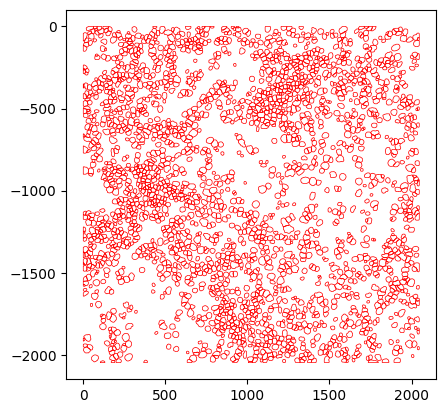

In [26]:
# confirm outlines are as expected
def plot_polygons(polygon_dict):
    fig, ax = plt.subplots()
    
    for name, coords in polygon_dict.items():
        x, y = coords
        polygon = Polygon(np.column_stack([x, y]), fill = None, edgecolor = 'r', linewidth = 0.5)
        ax.add_patch(polygon)
    ax.autoscale()
    ax.set_aspect('equal')
    plt.show()

plot_polygons(geometry)

In [27]:
# save out cell geometries to be used in second script
filename = "kidney_expanded_cell_geometries.json"
file_dir = os.path.join(root_dir, 'example_data', 'kidney', 'segmentations') 

# Create the full file path
file_path = os.path.join(file_dir, filename)

# Write the JSON data to the file
with open(file_path, "w") as f:
    json.dump(geometry, f)


In [27]:
# save out for use in other script, simple check
pd.DataFrame({"outline_keys":list(geometry.keys())[0:100], 
              "df_derived":plot_df.index.tolist()[0:100]})


outline_keys       df_derived
0   drfXArg153cyIJv  drfXArg153cyIJv
1   v2dkivJvSpka5BX  v2dkivJvSpka5BX
2   f4MyeauUCg5cfQj  f4MyeauUCg5cfQj
3   iY6bs6BKEqE1cXt  iY6bs6BKEqE1cXt
4   vHZEn0MOHKZ9uaz  vHZEn0MOHKZ9uaz
..              ...              ...
95  SO7ikwSLii99ZtA  SO7ikwSLii99ZtA
96  jkDrNoN0msmLMdW  jkDrNoN0msmLMdW
97  3t77XmNCblkXvNQ  3t77XmNCblkXvNQ
98  Zkucgpcwnfl6DBl  Zkucgpcwnfl6DBl
99  gJHdMQpPgA5jpRt  gJHdMQpPgA5jpRt

[100 rows x 2 columns]